In [1]:
""" Librerías """

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('darkgrid')
np.set_printoptions(precision=2) # 2 decimales en los números que se imprimen
warnings.filterwarnings("ignore")

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

""" Semilla """

seed = 99

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/eduardofc/data/main/titanic-2.csv')

print(f'Número de filas: {data.shape[0]}, Número de columnas:{data.shape[1]}')
data.head()

Número de filas: 891, Número de columnas:13


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [3]:
# data.duplicated().sum() # no hay filas duplicadas
# print(data.dtypes)
# data.isnull().sum()

data['Cabin'] = data['Cabin'].fillna(0)
data['hasCabin'] = data['Cabin'].apply(lambda x: 0 if x==0 else 1)

data = data.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1) # axis=1 indica que se borra por col
# necesario poner data = data.drop, sino no se "guardan" los cambios!

In [4]:
data['SibSp'] = data.SibSp.apply(lambda x: 2 if x>=2 else x)
data['Parch'] = data.Parch.apply(lambda x: 2 if x>=2 else x)
data['Title'] = data.Title.apply(lambda x: x if x in ['Mr','Mrs','Miss'] else 'Otros')

In [5]:
# print(len(data))
data = data[~data.Embarked.isnull()] # eliminar esos 2 registros
# print(len(data))
# data.isnull().sum()

print( data.duplicated().sum() ) # en el df orig no hay duplicados, pero ahora sí hay, por las agrupaciones de categorías

data = data.drop_duplicates()
# data = data[~data.duplicated()] # otra forma

data.duplicated().sum() # comprobamos que se ha corregido el problema

102


0

In [6]:
# data.isnull().sum()

col_transformer = ColumnTransformer(
    [
    ('imputer', KNNImputer(n_neighbors=5, metric='nan_euclidean'), ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']), # default: weights='uniform'
    ('yeojohnson', PowerTransformer(), ['Fare']), # default: method='yeo-johnson'
    ('encoder1', OneHotEncoder(drop='if_binary'), ['Sex']), # drop first only in variabs with 2 categories
    ('encoder2', OneHotEncoder(drop='first'), ['Embarked']), # drops first category in every variab
    ('encoder3', OneHotEncoder(), ['Title','Parch']) # default: drop=None
    ],
    remainder='drop') # remainder='passthrough' para no descartar las demás variabs que no hemos indicado

In [7]:
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier(random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('RFC', RandomForestClassifier(random_state=seed)))
models.append(('SVM', SVC()))

X = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'hasCabin']]
y = data['Survived']

def boxplots_algorithms(results, names):
    
    plt.figure(figsize=(8,8))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.show()

In [8]:
# EXTRA (no lo pide el ejerc, pero me parece importante saber identificar las cols de X transformadas)

# Además: DUDA profe sobre col 'Fare' duplicada!!!

print(X)

X_new = col_transformer.fit_transform(X)

new_col_names_imputer = col_transformer.named_transformers_['imputer'].get_feature_names_out()
new_col_names_yeojohnson = col_transformer.named_transformers_['yeojohnson'].get_feature_names_out()
new_col_names_encoder1 = col_transformer.named_transformers_['encoder1'].get_feature_names_out()
new_col_names_encoder2 = col_transformer.named_transformers_['encoder2'].get_feature_names_out()
new_col_names_encoder3 = col_transformer.named_transformers_['encoder3'].get_feature_names_out()

all_col_names = list(new_col_names_imputer) + list(new_col_names_yeojohnson) + list(new_col_names_encoder1) + list(new_col_names_encoder2) + list(new_col_names_encoder3)

print(pd.DataFrame(X_new, columns=all_col_names))
## ojo que tenemos Fare duplicada (la orig y la yeojohnson --> quizás corregir los nombres manualmente en pd.DataFrame(X_new))

""" Pero entonces, si Fare aparece tanto la orig como la transformada con YeoJohnson... se usan ambas para entrenar??
Veamos una cosa... """

X_new_2 = RobustScaler().fit_transform(X_new)

print(pd.DataFrame(X_new_2, columns=all_col_names))

## respuesta profe en celda siguiente!!!

     Pclass     Sex   Age  SibSp  Parch     Fare Embarked  Title  hasCabin
0         3    male  22.0      1      0   7.2500        S     Mr         0
1         1  female  38.0      1      0  71.2833        C    Mrs         1
2         3  female  26.0      0      0   7.9250        S   Miss         0
3         1  female  35.0      1      0  53.1000        S    Mrs         1
4         3    male  35.0      0      0   8.0500        S     Mr         0
..      ...     ...   ...    ...    ...      ...      ...    ...       ...
886       2    male  27.0      0      0  13.0000        S  Otros         0
887       1  female  19.0      0      0  30.0000        S   Miss         1
888       3  female   NaN      1      2  23.4500        S   Miss         0
889       1    male  26.0      0      0  30.0000        C     Mr         1
890       3    male  32.0      0      0   7.7500        Q     Mr         0

[787 rows x 9 columns]
     Pclass   Age  SibSp  Parch     Fare      Fare  Sex_male  Embarked_Q  \


In [9]:
# la forma del profe es más elegante para obtener X_new con los nombres de las cols bien puestos

X_new = col_transformer.fit_transform(X)
df_ct = pd.DataFrame(X_new, columns=col_transformer.get_feature_names_out())
df_ct.head()

# efectivamente, Fare está duplicada. Esto es porque en column_transformer la estamos metiendo en 2 transformadores, y todo
# lo que va en un column_transformer se aplica "a la vez", no uno detrás de otro. Si queremos hacerlo bien, rollo aplicar 
# primero el imputer y después la transformación yeo-johnson, entonces tenemos que hacerlo por separado (por ej, con dos column_transformer,
# aunque igual no es necesario). Un ejemplo similar lo hacemos en Ejerc 2 - Modelo 4 ;)

,imputer__Pclass,imputer__Age,imputer__SibSp,imputer__Parch,imputer__Fare,yeojohnson__Fare,encoder1__Sex_male,encoder2__Embarked_Q,encoder2__Embarked_S,encoder3__Title_Miss,encoder3__Title_Mr,encoder3__Title_Mrs,encoder3__Title_Otros,encoder3__Parch_0,encoder3__Parch_1,encoder3__Parch_2
0,3.0,22.0,1.0,0.0,7.2500,-0.973851,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0,38.0,1.0,0.0,71.2833,1.273806,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,3.0,26.0,0.0,0.0,7.9250,-0.882512,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,35.0,1.0,0.0,53.1000,1.004376,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,3.0,35.0,0.0,0.0,8.0500,-0.866442,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [10]:
# por ahora, no han pedido esto

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

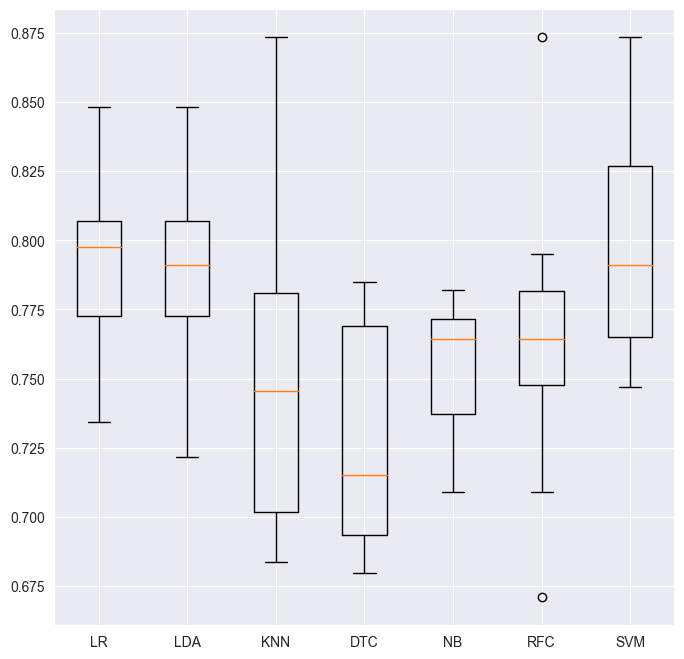

In [11]:
results = []
names = []
for name, model in models:
    pipe = Pipeline([
        ('column_transform', col_transformer),
        ('scaler', RobustScaler()),
        ('algorithm', model)        
    ])
    # pipe = make_pipeline(col_transformer, RobustScaler(), model) # otra forma
    kf = KFold(n_splits=10, shuffle=True, random_state=seed) # random_state es la seed
    cv_results = cross_val_score(
        estimator=pipe,
        X=X,
        y=y,
        cv=kf, 
        scoring='accuracy' # métrica
    )
    results.append(cv_results)
    names.append(name)

boxplots_algorithms(results, names)

### GridSearchCV

In [12]:
# RandomForest consiste en hacer varios árboles y luego agregar sus resultados para obtener la predicción final.
# Para generar esos árboles, hace Boostrapping para seleccionar subdatasets, y hace Random Feature Selection para cada árbol.
# Cuántas variables coger para cada árbol? Si hay Z variables, se suele coger sqrt(Z) o log(Z)

# RandomForestClassifier()
    # n_estimators : 10 o 20, número de árboles en el RForest
    # max_features : sqrt(dfto), log2, auto (=sqrt), None (coge todas)
    # max_depth : 4,5,6,7,8
    # criterion : {“gini”, “entropy”, “log_loss”}, default=”gini”
    
# ahora solo este modelo
model = RandomForestClassifier(random_state=seed) # no olvidar la seed

# mismo pipeline que antes
pipe = Pipeline([
        ('column_transform', col_transformer),
        ('scaler', RobustScaler()),
        ('algorithm', model)        
    ])    

#método de entrenamiento
cv_technique = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed) # True para que sea aleatorio

# malla de paráms
parametros = {
    "algorithm__n_estimators": [10,20], # así se indica de qué fase del pipeline son
    "algorithm__max_features": ['sqrt','auto','log2'],
    "algorithm__max_depth": [4,5,6,7,8],
    "algorithm__criterion": ['gini','entropy']
}

# train-test split: en este ejemplo lo omitimos

# combinamos todo
gsearch = GridSearchCV(estimator=pipe, cv=cv_technique, param_grid=parametros)

# buscamos el mejor modelo
grid_model = gsearch.fit(X, y)


print(grid_model.best_score_)
print(grid_model.best_estimator_)

0.80688088283025
Pipeline(steps=[('column_transform',
                 ColumnTransformer(transformers=[('imputer', KNNImputer(),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('yeojohnson',
                                                  PowerTransformer(),
                                                  ['Fare']),
                                                 ('encoder1',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Sex']),
                                                 ('encoder2',
                                                  OneHotEncoder(drop='first'),
                                                  ['Embarked']),
                                                 ('encoder3', OneHotEncoder(),
                                       

In [52]:
grid_model.best_score_

0.80688088283025

In [53]:
grid_model.best_estimator_

Pipeline(steps=[('column_transform',
                 ColumnTransformer(transformers=[('imputer', KNNImputer(),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('yeojohnson',
                                                  PowerTransformer(),
                                                  ['Fare']),
                                                 ('encoder1',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Sex']),
                                                 ('encoder2',
                                                  OneHotEncoder(drop='first'),
                                                  ['Embarked']),
                                                 ('encoder3', OneHotEncoder(),
                                                  ['Title', 'Parch'])])),
                ('scaler', RobustScaler()),
                ('algorithm',
                 RandomForestClassifier(max_depth=6, n_estimators=10,
                                        random_state=99))])